# Binary Prediction of Poisonous Mushrooms

### 1. Business Understanding

* Source: This dataset will come from the Kaggle competition found at https://www.kaggle.com/competitions/playground-series-s4e8/overview
* Goal: The goal of this competition is to predict whether a mushroom is edible or poisonous based on its physical characteristics.
* Evaluation: Submissions are evaluated using the Matthews correlation coefficient (MCC).
* Submission: For each id row in the test set, you must predict target class, whether the observation is edible (e) or poisonous (p).

### 2. Data Understanding

Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Warnings
import warnings
warnings.filterwarnings('ignore')


Import Data

In [3]:
# Train Dataset
train = pd.read_csv("train.csv")

# Test Dataset
test = pd.read_csv("test.csv")


Describe Data

In [3]:
print("The training dataset has", train.shape[0], "rows")
print("The training dataset has", train.shape[1], "columns")

print("The columns in the dataset have the following types:")
train.dtypes

The training dataset has 3116945 rows
The training dataset has 22 columns
The columns in the dataset have the following types:


id                        int64
class                    object
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dtype: object

Analyze the Predictor

* Looks like there is a pretty even split between edible (e) and poisonous (p) rows

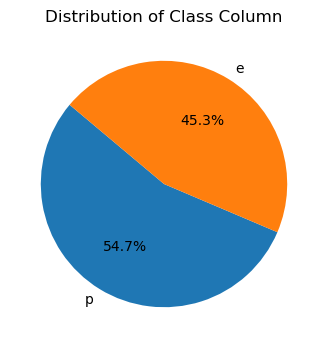

In [3]:
# Count the occurrences of each class
class_counts = train['class'].value_counts()

# Define colors (optional)
colors = ['#1f77b4', '#ff7f0e']

# Create pie chart
plt.figure(figsize=(4, 4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=colors, startangle=140)

# Title
plt.title("Distribution of Class Column")

# Show plot
plt.show()

Numerical Column Analysis

In [19]:
num_cols = train.select_dtypes(include=["int64", "float64"]).columns

# Describe data
train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
id,3116945.0,1.558472e+06,899784.661740,0.00,779236.00,1558472.00,2337708.00,3116944.00
cap-diameter,3116941.0,6.309848e+00,4.657931,0.03,3.32,5.75,8.24,80.67
stem-height,3116945.0,6.348333e+00,2.699755,0.00,4.67,5.88,7.41,88.72
stem-width,3116945.0,1.115379e+01,8.095477,0.00,4.97,9.65,15.63,102.90


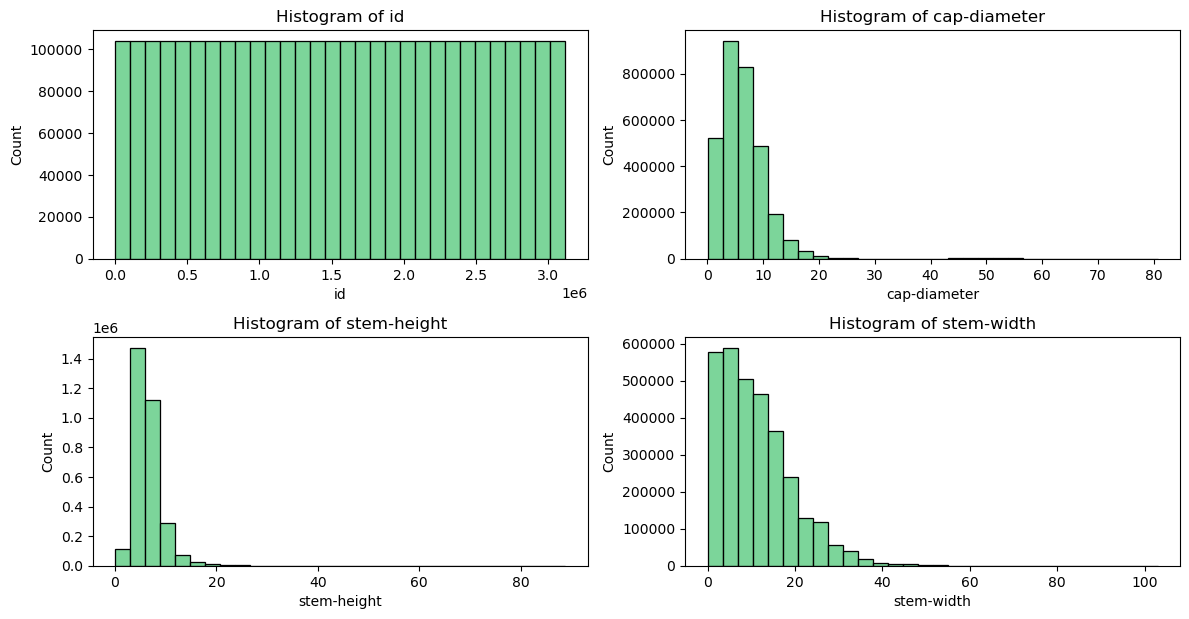

In [20]:
# Set up the figure size
plt.figure(figsize=(12, len(num_cols) * 3))

# Plot histograms for each numerical column
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 2, i)
    sns.histplot(train[col], bins=30, kde=False, color="#50C878")
    plt.title(f"Histogram of {col}")

# Adjust layout
plt.tight_layout()
plt.show()

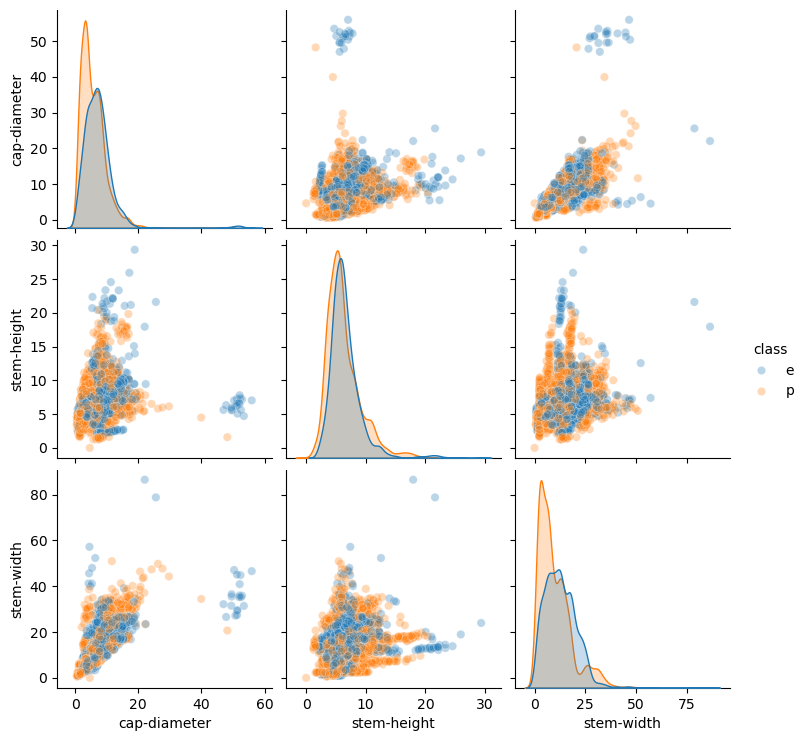

In [10]:
sns.pairplot(train.drop(columns=["id"]).head(5000), hue = "class", plot_kws={'alpha': 0.3})

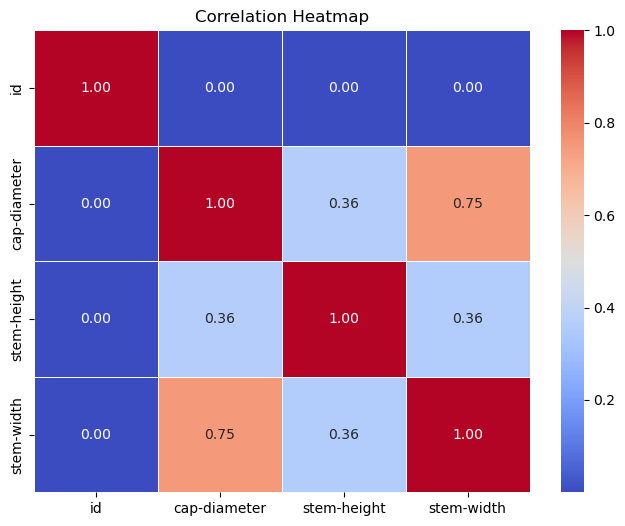

In [20]:
# Compute correlation matrix
corr_matrix = train[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Categorical Variable Analysis

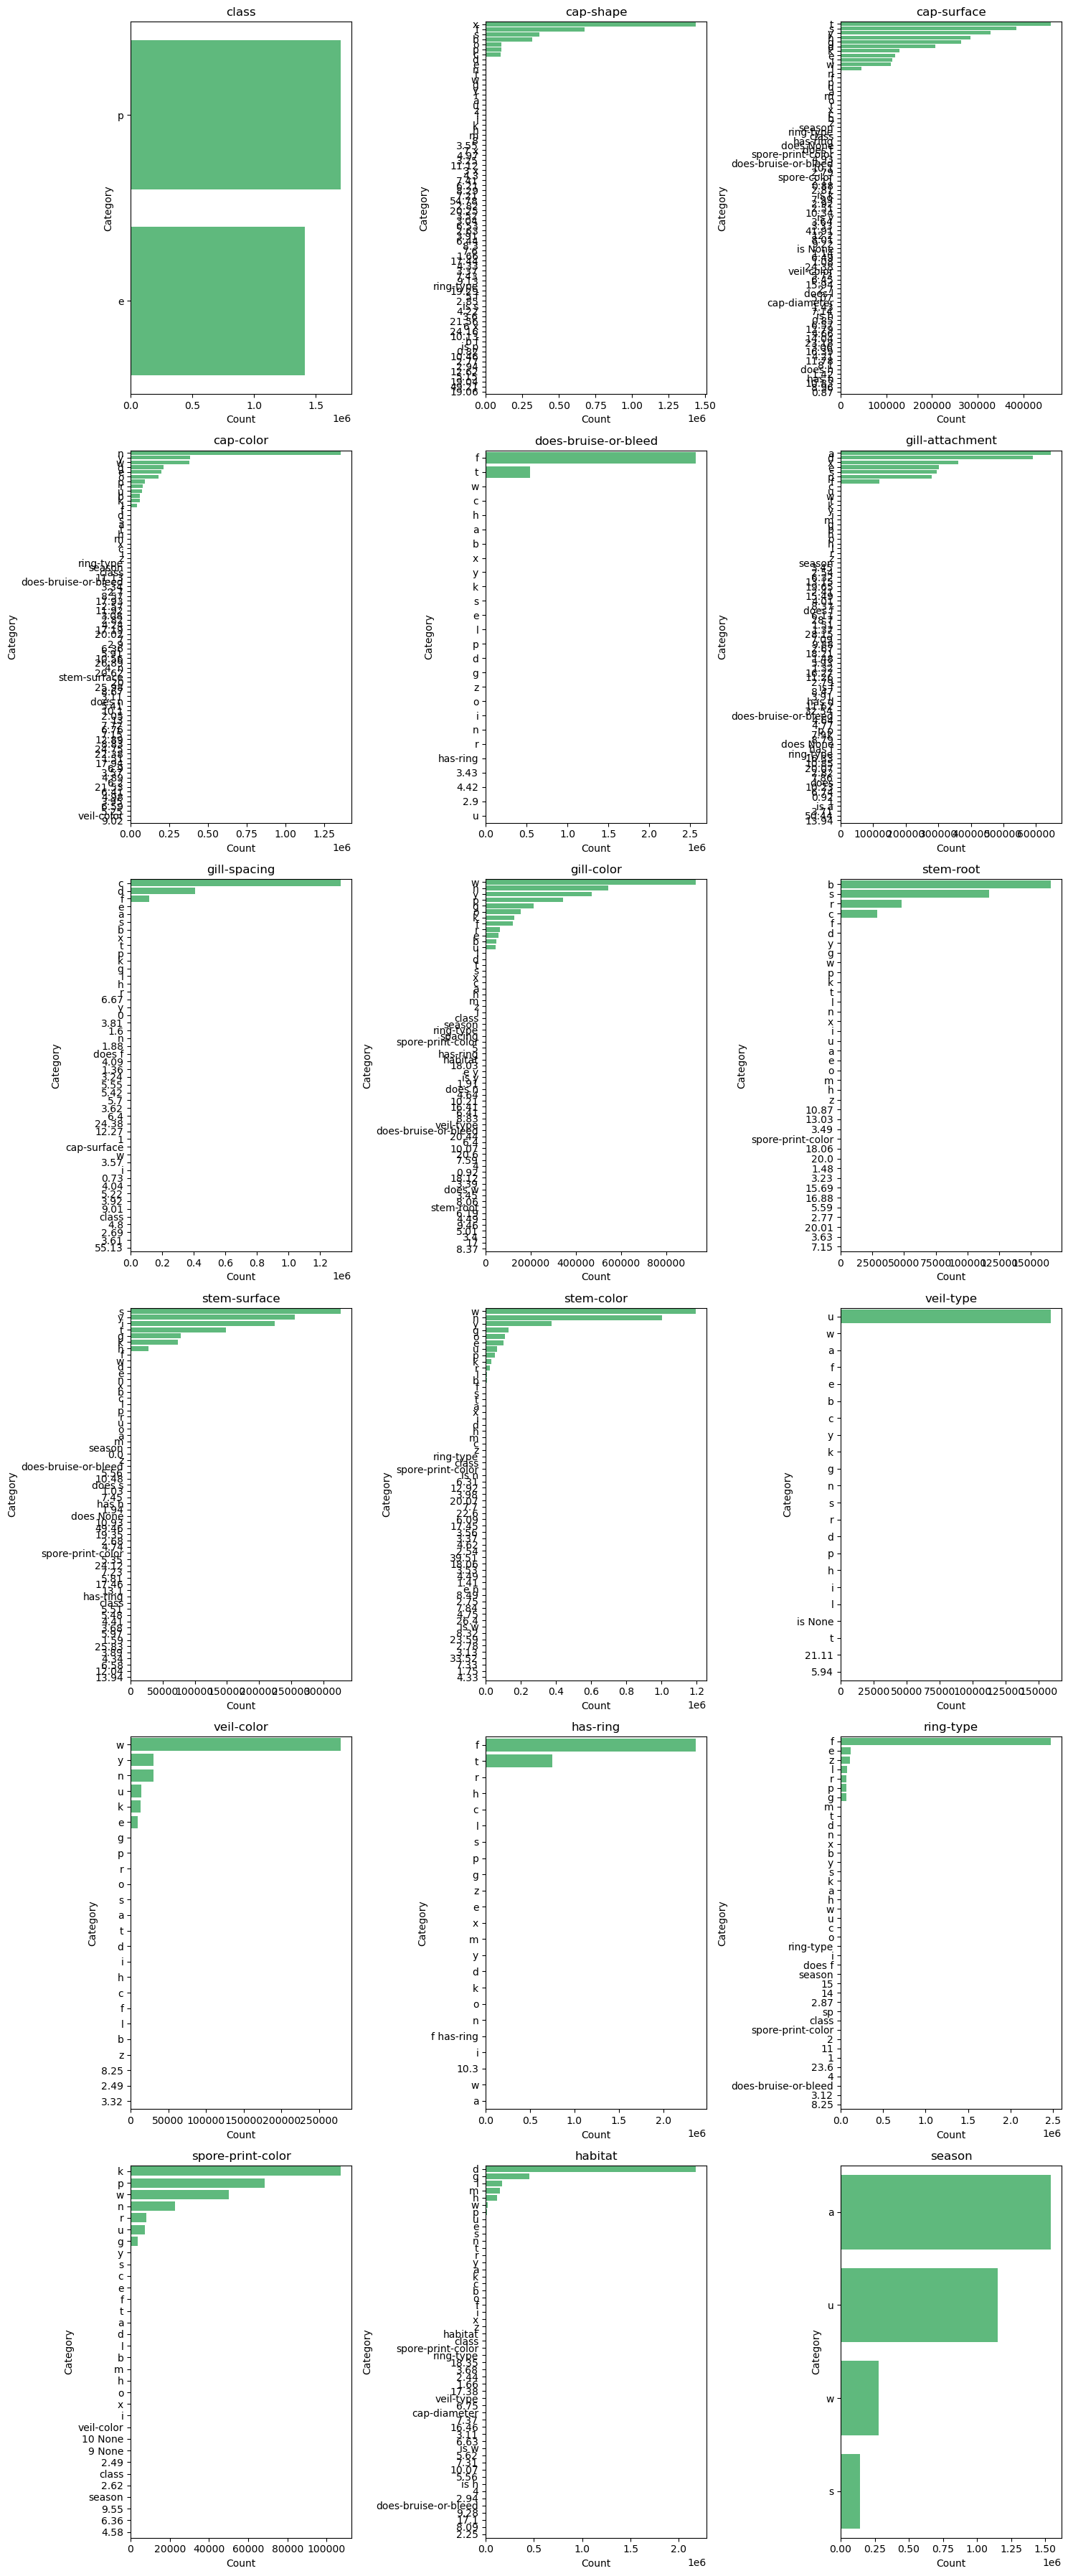

In [3]:
# Frequency distribution of each categorical column
categorical_cols = train.select_dtypes(include=["object"]).columns

# Set up figure size (3 columns per row)
n_cols = 3
n_rows = (len(categorical_cols) // n_cols) + (len(categorical_cols) % n_cols > 0)  # Calculate number of rows

plt.figure(figsize=(15, n_rows * 6))

# Loop through categorical columns and create horizontal bar plots
for i, col in enumerate(categorical_cols, 1):
    # Get the top 12 value counts
    top_12 = train[col].value_counts()
    
    # Create subplot (3 columns per row)
    plt.subplot(n_rows, n_cols, i)
    sns.barplot(x=top_12.values, y=top_12.index, color="#50C878")
    plt.title(f"{col}")
    plt.xlabel("Count")
    plt.ylabel("Category")
    
plt.tight_layout()
plt.show()

* Handle high cardinality within the dataset
    * This should also handle all of the categories that are mislabelled
    * We will only keep categories with at least 5% of the total rows of data, everything else we will set as "Other"

In [4]:
# Frequency distribution of each categorical column
categorical_cols = train.select_dtypes(include=["object"]).columns

# Threshold for grouping rare categories (e.g., categories appearing less than 5% of the time)
threshold = 0.05

# For each categorical column in the DataFrame
for col in train.select_dtypes(include=["object"]).columns:
    # Create a mapping for rare categories
    category_counts = train[col].value_counts(normalize=True)
    rare_categories = category_counts[category_counts < threshold].index
    
    # Replace rare categories with 'Other'
    train[col] = train[col].replace(rare_categories, 'Other')

# Look at the Unique Values for 1 column
train['cap-shape'].unique()

array(['f', 'x', 'Other', 'b', 's', nan], dtype=object)

* Redo the Frequency Distributions

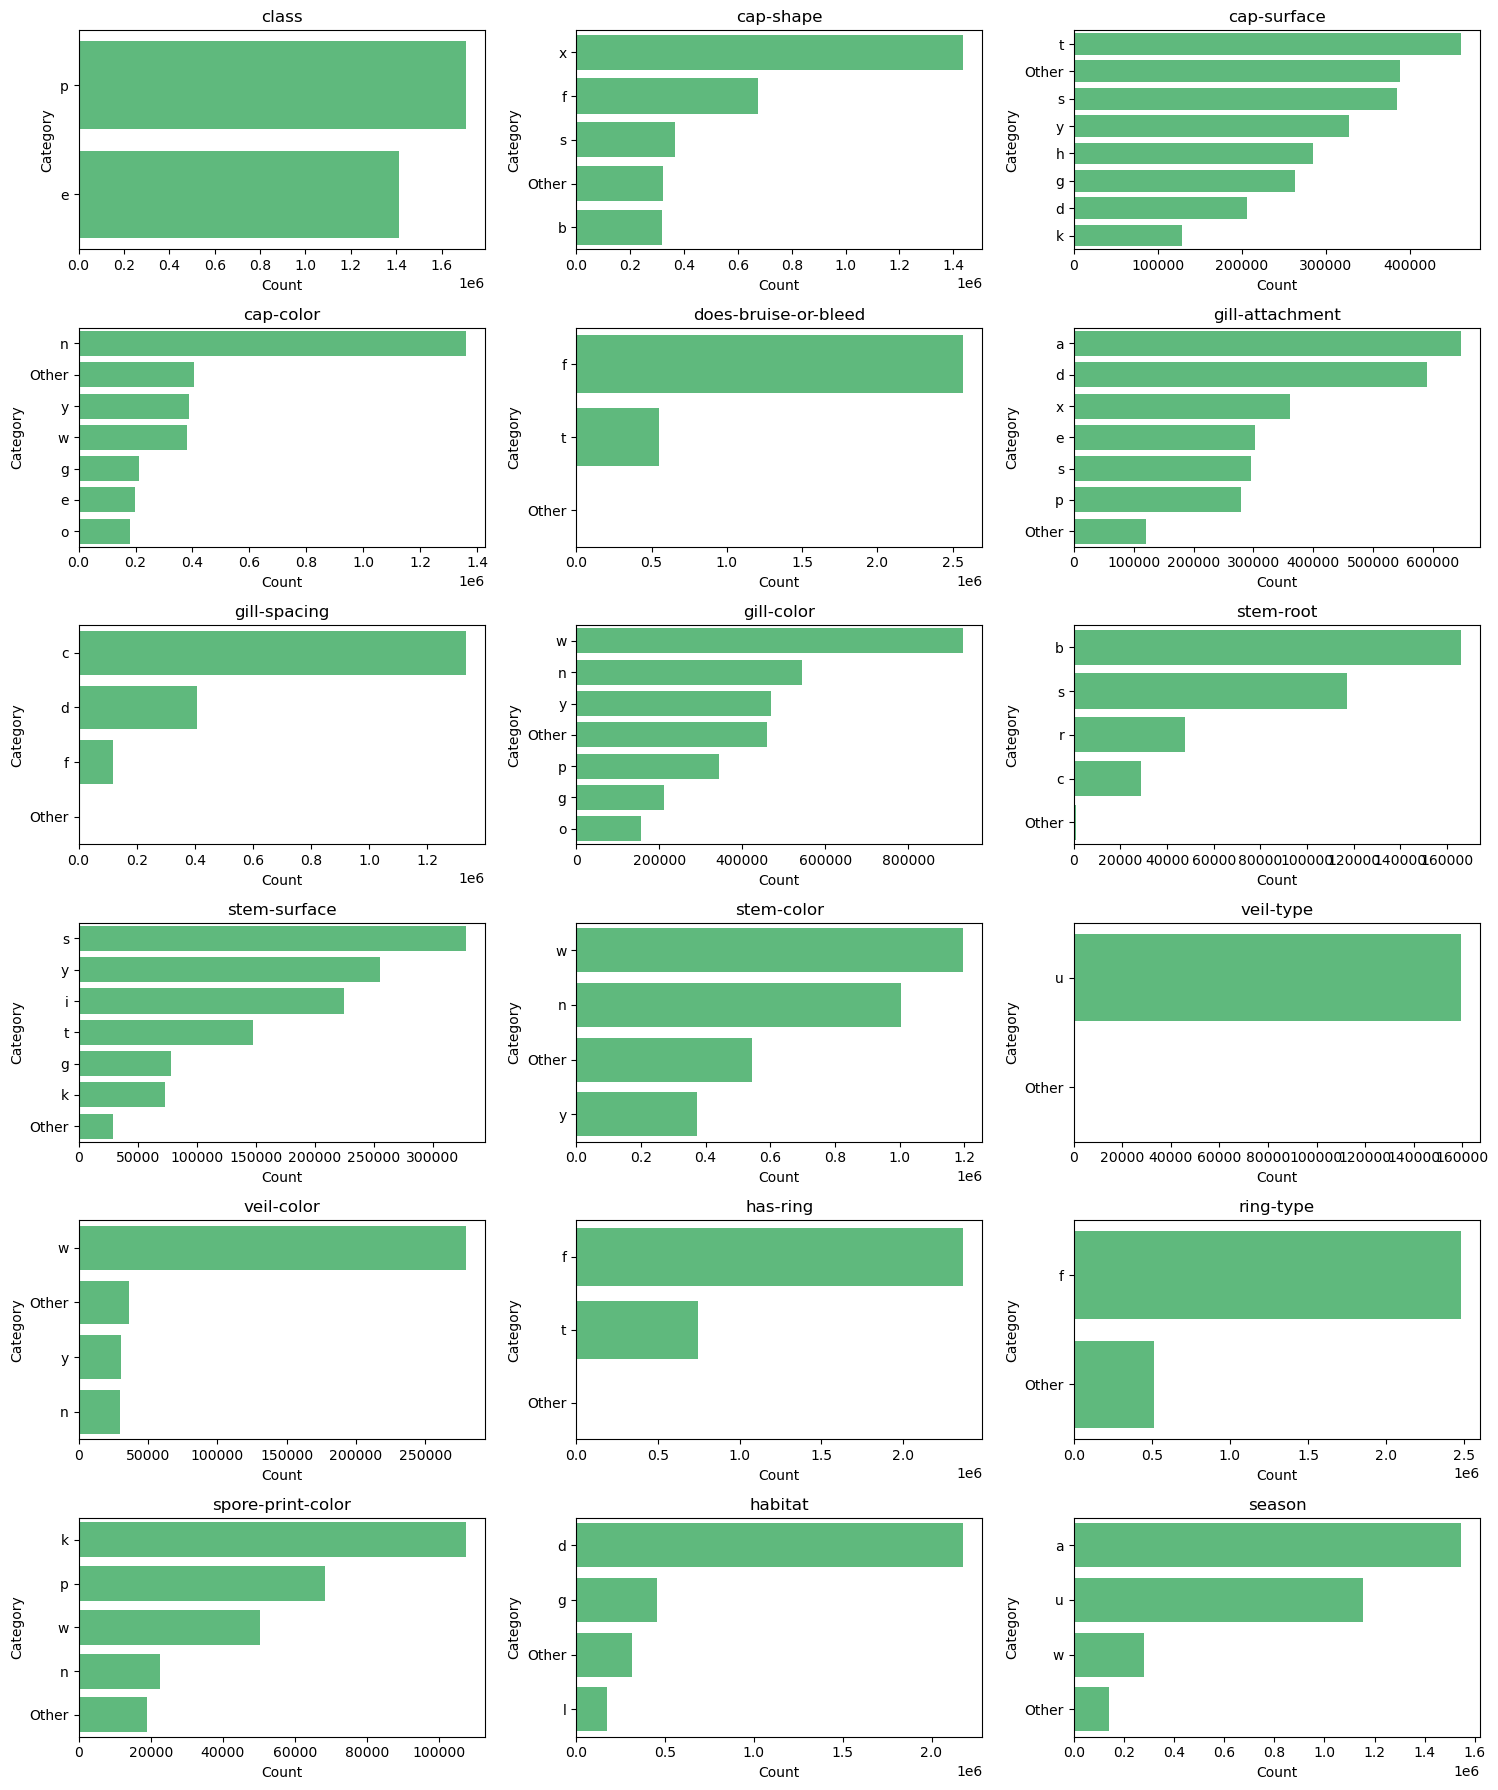

In [5]:
# Frequency distribution of each categorical column
categorical_cols = train.select_dtypes(include=["object"]).columns

# Set up figure size (3 columns per row)
n_cols = 3
n_rows = (len(categorical_cols) // n_cols) + (len(categorical_cols) % n_cols > 0)  # Calculate number of rows

plt.figure(figsize=(15, n_rows * 3))

# Loop through categorical columns and create horizontal bar plots
for i, col in enumerate(categorical_cols, 1):
    # Get the top 12 value counts
    top_12 = train[col].value_counts()
    
    # Create subplot (3 columns per row)
    plt.subplot(n_rows, n_cols, i)
    sns.barplot(x=top_12.values, y=top_12.index, color="#50C878")
    plt.title(f"{col}")
    plt.xlabel("Count")
    plt.ylabel("Category")
    
plt.tight_layout()
plt.show()

* Now let's look at the proportions of each category that is edible vs poisonous

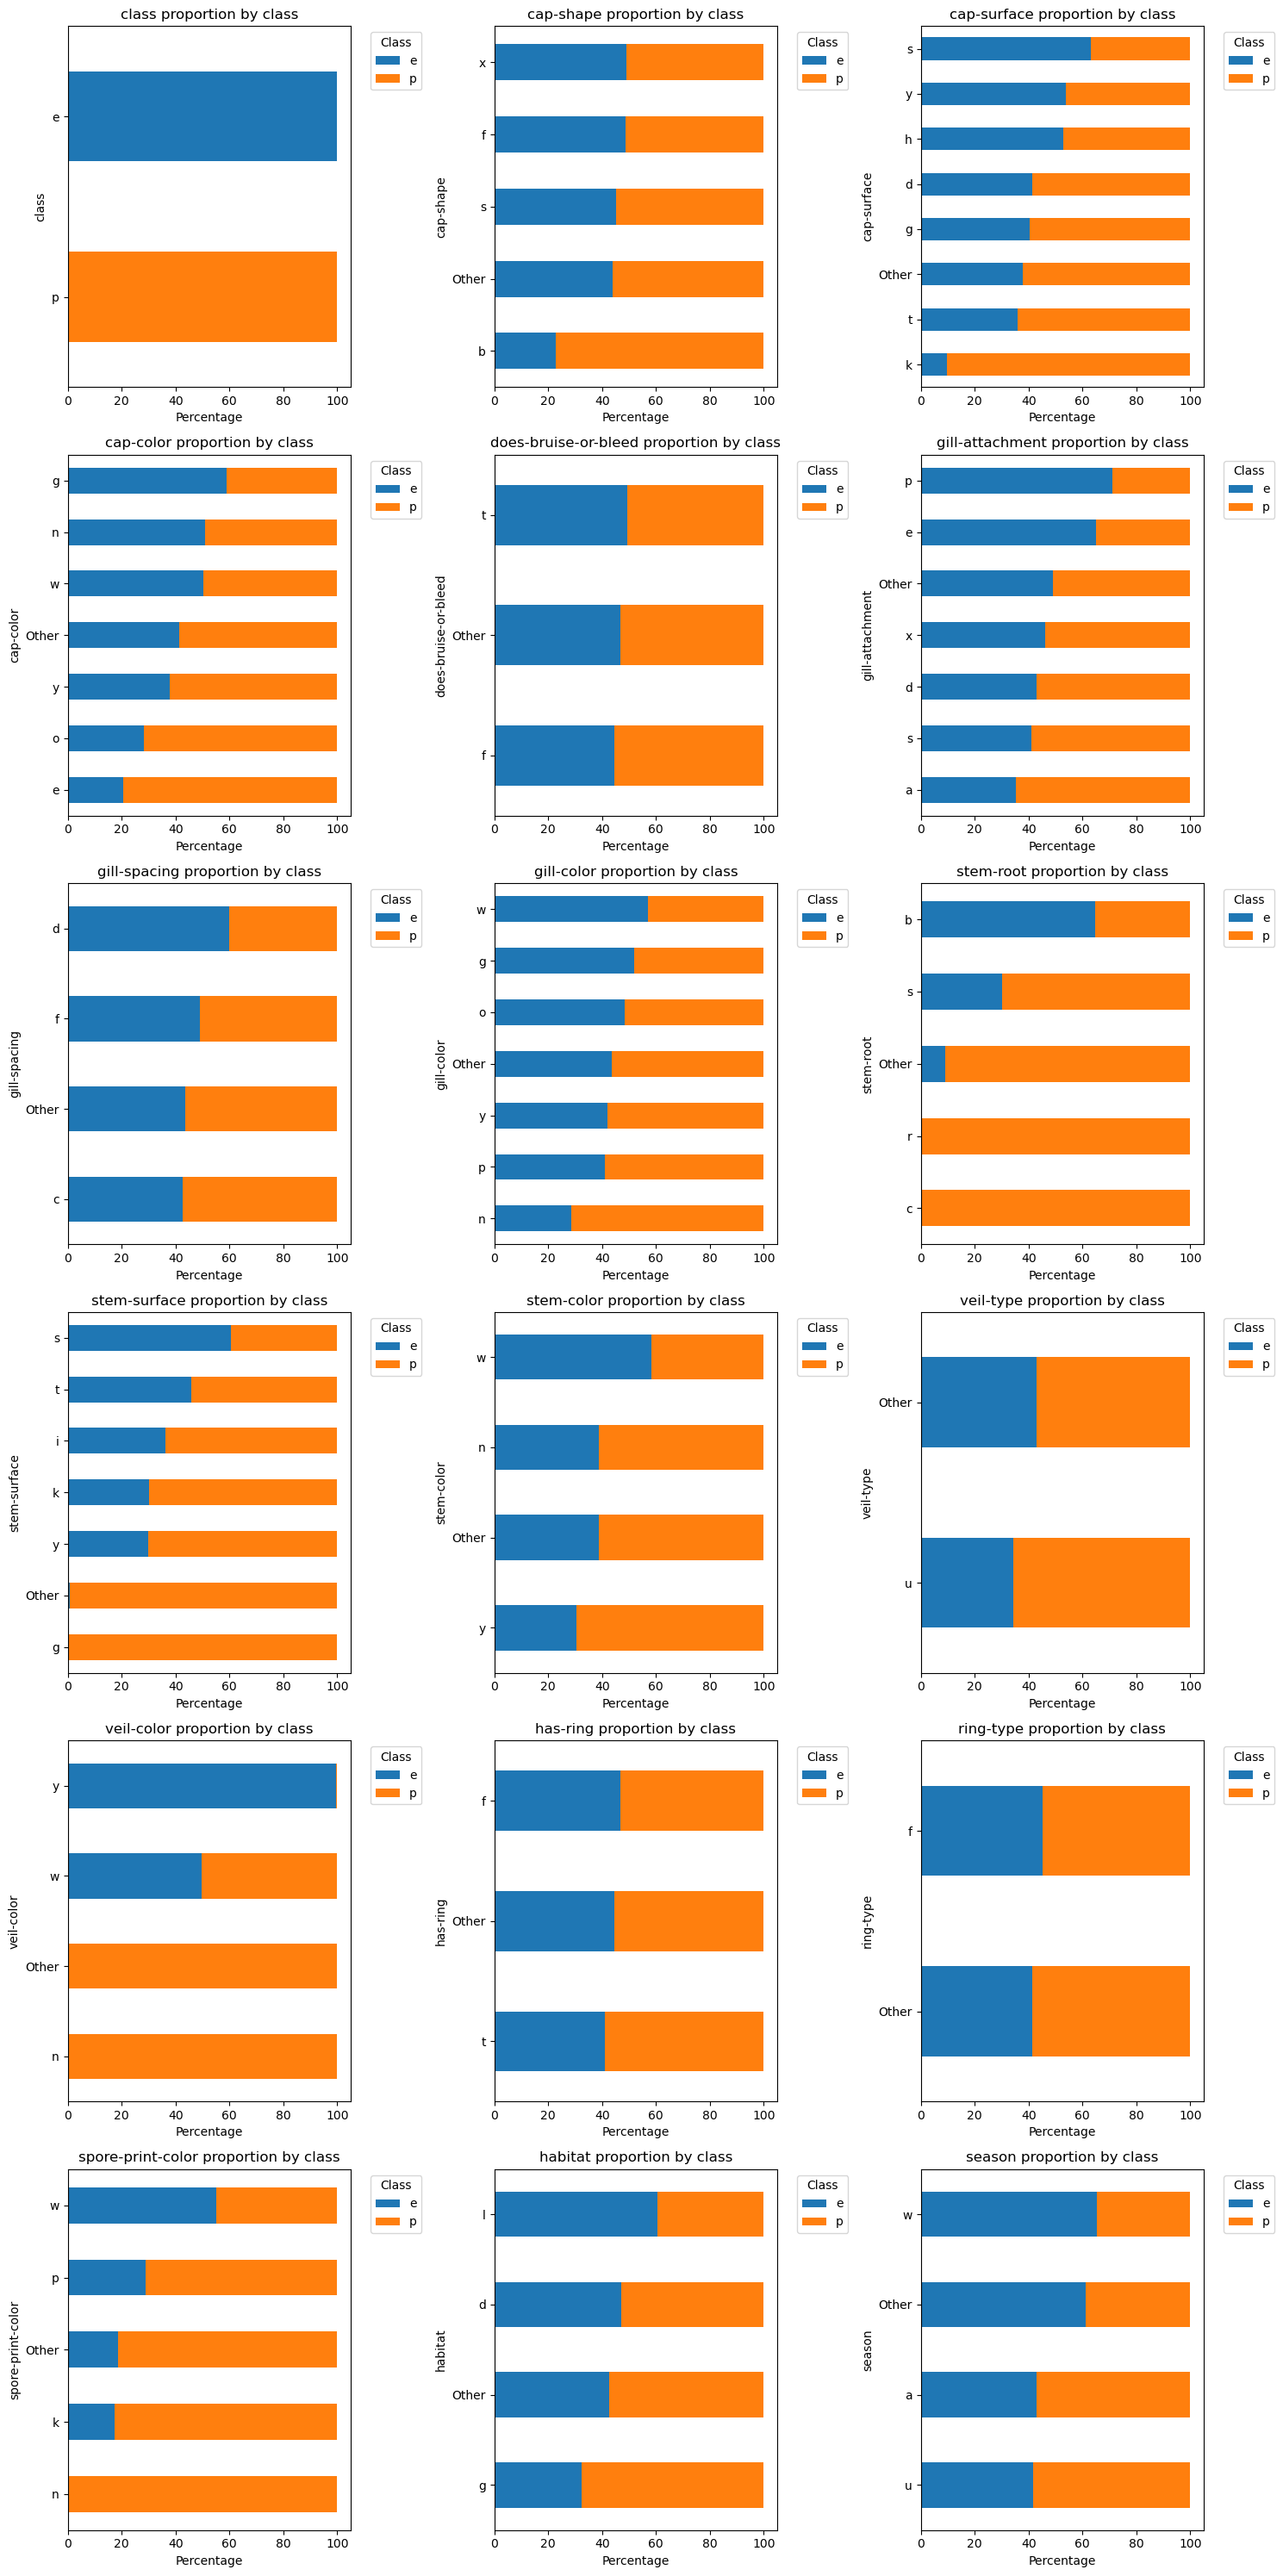

In [6]:
# Set up figure size for multiple plots
n_cols = 3
n_rows = (len(categorical_cols) // n_cols) + (len(categorical_cols) % n_cols > 0)
plt.figure(figsize=(15, n_rows * 5))

custom_colors = {
    'e': '#1f77b4',
    'p': '#ff7f0e',
}

# Get unique class labels to apply the color mapping dynamically
class_labels = train['class'].unique()

# Generate the color list based on class labels
color_list = [custom_colors.get(cls, '#d62728') for cls in class_labels]  

# Loop through each categorical column and plot a 100% stacked bar chart
for i, col in enumerate(categorical_cols, 1):
    # Group by the categorical column and class, and get the counts
    col_class_counts = train.groupby([col, 'class']).size().unstack().fillna(0)
    
    # Normalize each row to get proportions (i.e., make it a 100% stacked bar)
    col_class_counts = col_class_counts.div(col_class_counts.sum(axis=1), axis=0) * 100
    
    # Sort categories by the proportion of class 'e' (assuming 'e' is one of the class labels)
    sorted_categories = col_class_counts['e'].sort_values(ascending=True).index
    col_class_counts_sorted = col_class_counts.loc[sorted_categories]
    
    # Create a subplot for each categorical column
    plt.subplot(n_rows, n_cols, i)
    col_class_counts_sorted.plot(kind='barh', stacked=True, color=color_list, ax=plt.gca())
    
    # Formatting for each subplot
    plt.title(f"{col} proportion by class")
    plt.xlabel("Percentage")
    plt.ylabel(col)
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### 3. Data Preparation

Missing Data Handling

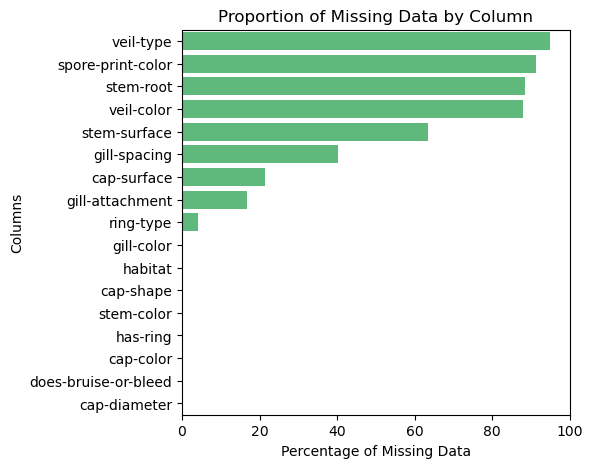

In [5]:
missing_percent = train.isnull().sum() / len(train) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending = False)

plt.figure(figsize=(5, 5))
sns.barplot(x=missing_percent.values, y=missing_percent.index, color="#50C878")

# Formatting
plt.xlabel("Percentage of Missing Data")
plt.ylabel("Columns")
plt.title("Proportion of Missing Data by Column")
plt.xlim(0, 100)
plt.show()

In [5]:
# Drop columns with 80%+ missing data
threshold = 0.8

# Get columns to drop
missing_percent = train.isnull().mean()
columns_to_drop = missing_percent[missing_percent > threshold].index

# Drop the columns
train = train.drop(columns=columns_to_drop)

print(f"Dropped {len(columns_to_drop)} columns with over {threshold*100}% missing values.")

Dropped 4 columns with over 80.0% missing values.


In [6]:
# Create an Unknown group for Categorical Variables
train['stem-surface'] = train['stem-surface'].fillna("Missing")
train['gill-spacing'] = train['gill-spacing'].fillna("Missing")
train['cap-surface'] = train['cap-surface'].fillna("Missing")
train['gill-attachment'] = train['gill-attachment'].fillna("Missing")
train['ring-type'] = train['ring-type'].fillna("Missing")

# Remove the rows for the remaining columns with missing data
train = train.dropna()

One-Hot Encode Categorical Variables from Categorical Columns
* This will help with certain models

In [7]:
# Identify categorical columns
categorical_cols = train.select_dtypes(include=["object"]).columns

# Apply one-hot encoding
train_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=True)

### 4. Modelling

Models
* Logistic Regression
* Random Forest
* XGBoost
* CatBoost
* LGBM


Split the Data

In [9]:
# Split into X and y
X = train_encoded.drop(columns=['id', 'class_p'])
y = train_encoded["class_p"]

# Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 123)

Logistic Regression

              precision    recall  f1-score   support

       False       0.74      0.74      0.74    282288
        True       0.79      0.79      0.79    341056

    accuracy                           0.77    623344
   macro avg       0.76      0.76      0.76    623344
weighted avg       0.77      0.77      0.77    623344

Matthews Correlation Coefficient: 0.5289


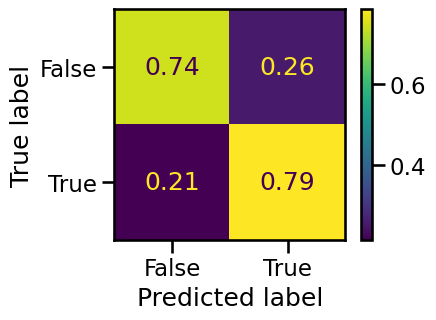

['Logistic Regression.pkl']

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, matthews_corrcoef
import joblib

logit_model = LogisticRegression()

# Train the model
logit_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logit_model.predict(X_test)

# Evaluate Model
print(classification_report(y_test, y_pred))

mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Create a confusion matrix
cf = confusion_matrix(y_test, y_pred, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=logit_model.classes_)

fig, ax = plt.subplots(figsize=(4, 3))  # Adjust size as needed
disp.plot(ax=ax)
plt.show()

# Save Model
joblib.dump(logit_model, "Logistic Regression.pkl")

Random Forest

              precision    recall  f1-score   support

       False       0.99      0.99      0.99    282288
        True       0.99      0.99      0.99    341056

    accuracy                           0.99    623344
   macro avg       0.99      0.99      0.99    623344
weighted avg       0.99      0.99      0.99    623344

Matthews Correlation Coefficient: 0.9833


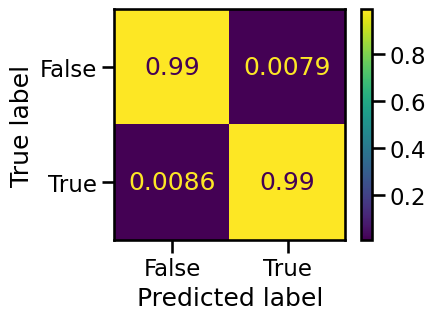

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, matthews_corrcoef
import joblib

# Create Model
rf_model = RandomForestClassifier(random_state=42)

# Fit Model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate Model
print(classification_report(y_test, y_pred))

mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Create a confusion matrix
cf = confusion_matrix(y_test, y_pred, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=logit_model.classes_)

fig, ax = plt.subplots(figsize=(4, 3))  # Adjust size as needed
disp.plot(ax=ax)
plt.show()

# Save Model
joblib.dump(rf_model, "Random Forest.pkl")

XGBoost

              precision    recall  f1-score   support

       False       0.99      0.99      0.99    282288
        True       0.99      0.99      0.99    341056

    accuracy                           0.99    623344
   macro avg       0.99      0.99      0.99    623344
weighted avg       0.99      0.99      0.99    623344

Matthews Correlation Coefficient: 0.9813


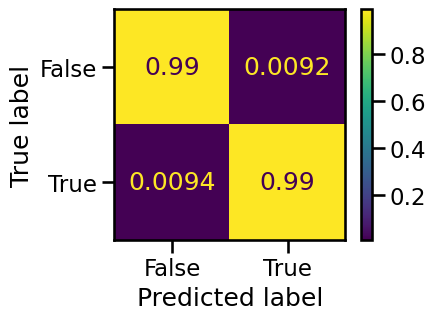

['XGBoost.pkl']

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, matthews_corrcoef
import joblib

# Create Model
xgb_model = XGBClassifier(
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Logarithmic loss
    use_label_encoder=False       # Avoid deprecated warning
)

# Fit Model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate Model
print(classification_report(y_test, y_pred))

mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Create a confusion matrix
cf = confusion_matrix(y_test, y_pred, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=logit_model.classes_)

fig, ax = plt.subplots(figsize=(4, 3))  # Adjust size as needed
disp.plot(ax=ax)
plt.show()

# Save Model
joblib.dump(xgb_model, "XGBoost.pkl")

CatBoost

0:	learn: 0.6412974	test: 0.6410878	best: 0.6410878 (0)	total: 467ms	remaining: 7m 46s
200:	learn: 0.0515043	test: 0.0519390	best: 0.0519390 (200)	total: 1m 20s	remaining: 5m 19s
400:	learn: 0.0419993	test: 0.0428666	best: 0.0428666 (400)	total: 2m 39s	remaining: 3m 58s
600:	learn: 0.0400839	test: 0.0412434	best: 0.0412434 (600)	total: 3m 52s	remaining: 2m 34s
800:	learn: 0.0394486	test: 0.0407578	best: 0.0407578 (800)	total: 5m	remaining: 1m 14s
999:	learn: 0.0392265	test: 0.0405780	best: 0.0405780 (999)	total: 6m 5s	remaining: 0us

bestTest = 0.04057804064
bestIteration = 999

              precision    recall  f1-score   support

       False       0.99      0.99      0.99    282288
        True       0.99      0.99      0.99    341056

    accuracy                           0.99    623344
   macro avg       0.99      0.99      0.99    623344
weighted avg       0.99      0.99      0.99    623344

Matthews Correlation Coefficient: 0.9823


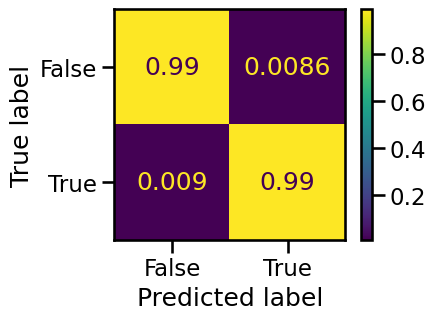

['CatBoost.pkl']

In [22]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, matthews_corrcoef
import joblib

# Create CatBoost model
cat_model = CatBoostClassifier(
    iterations=1000,         # Number of boosting iterations
    learning_rate=0.1,       # Learning rate
    depth=6,                 # Depth of trees
    loss_function='Logloss', # Suitable for binary classification
    verbose=200              # Print progress every 200 iterations
)

# Fit the model
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=200)

# Make predictions on the test set
y_pred = cat_model.predict(X_test)

# Evaluate Model
print(classification_report(y_test, y_pred))

mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Create a confusion matrix
cf = confusion_matrix(y_test, y_pred, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=logit_model.classes_)

fig, ax = plt.subplots(figsize=(4, 3))  # Adjust size as needed
disp.plot(ax=ax)
plt.show()

# Save Model
joblib.dump(cat_model, "CatBoost.pkl")

LGBM

[LightGBM] [Info] Number of positive: 1364222, number of negative: 1129151
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.198397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 879
[LightGBM] [Info] Number of data points in the train set: 2493373, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547139 -> initscore=0.189118
[LightGBM] [Info] Start training from score 0.189118
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    282288
        True       0.99      0.99      0.99    341056

    accuracy                           0.99    623344
   macro avg       0.99      0.99      0.99    623344
weighted avg       0.99      0.99      0.99    623344

Matthews Correlation Coefficient: 0.9755


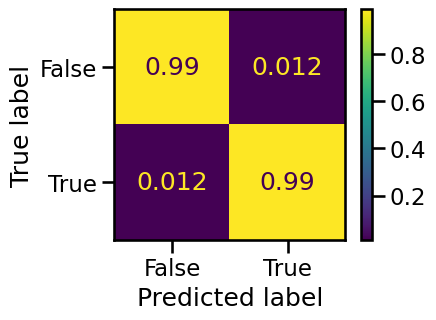

['LGBM.pkl']

In [26]:
import lightgbm as lgb
import joblib
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay

# Create LGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgb_model.predict(X_test)

# Evaluate Model
print(classification_report(y_test, y_pred))

mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Create a confusion matrix
cf = confusion_matrix(y_test, y_pred, normalize='true')

sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=logit_model.classes_)

fig, ax = plt.subplots(figsize=(4, 3))  # Adjust size as needed
disp.plot(ax=ax)
plt.show()

# Save Model
joblib.dump(lgb_model, "LGBM.pkl")


Review the Models

* The Random Forest model was best with a 0.9833 MCC, while the CatBoost was second with 0.9823, and XGBoost had a 0.9813.
* Because of the great scores we will skip any hyperparamater tuning for now. We can revisit this later if needed.